# Meta-Model



In [1]:
!pip install ta
!pip install catboost
!pip install openml
!pip install fancyimpute
import sys
import pandas as pd
from matplotlib import pyplot as plt
from itertools import combinations
import seaborn as sns
import calendar
import torch
import numpy as np
#from google.colab import data_table
from sklearn.cluster import SpectralClustering
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile, f_classif
from scipy import stats
import ta
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import RidgeClassifier
from scipy.stats import mstats
from sklearn.metrics import make_scorer
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import statsmodels.stats.diagnostic as smd
from sklearn.feature_selection import SelectKBest, f_classif, chi2, SelectFromModel, VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, VarianceThreshold
from sklearn.feature_selection import RFE
from sklearn.ensemble import VotingRegressor
from sklearn.feature_selection import SelectKBest, f_regression,SelectPercentile
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer, roc_auc_score, log_loss
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.tree import DecisionTreeRegressor
import pickle
from sklearn.feature_selection import RFE
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=84c52852024ddf728f7dea1bfff776c5601836f536c3c15624c96ffa130a0cdf
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 1.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.0 MB/s eta 0:00:00
  Created wheel for openml: filename=openml-0.14.2-py3-none-any.whl size=158699 sha256=7228be5f50ad53eb42370e8e50e81f135f2809829a65f4a7135095a5c12

In [2]:
#python version
print(sys.version)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


# Load data

In [22]:
data = pd.read_csv('/content/drive/MyDrive/DeafAbraxas/data/30m/EURUSD_30M.csv',delimiter=",",header=0,low_memory=False)
print(data.shape)

(67270, 8)


In [23]:
#convert datatime to_datetime
data.rename(columns={"time": "datetime"}, inplace=True)
data['datetime'] = pd.to_datetime(data['datetime'])

In [24]:
data = data.drop(columns=['real_volume'], axis=1)
print(data.shape)

(67270, 7)


In [25]:
initial_train_dataset_ = data[(data['datetime'] >= '2019-01-04 01:30:00') & (data['datetime'] <= '2022-06-30 23:30:00')]
initial_validation_dataset_ = data[(data['datetime'] > '2022-06-30 23:30:00') & (data['datetime'] <= '2023-06-30 23:30:00')]
non_seen_test_data = data[(data['datetime'] > '2023-06-30 23:30:00') & (data['datetime'] <= '2023-12-30 23:30:00')]
conformal_dataset_ = data[(data['datetime'] > '2023-12-30 23:30:00')]

In [26]:
#conformal_dataset_.to_csv('/content/drive/MyDrive/DeafAbraxas/data/30m/conformal_dataset.csv', index=False)

In [27]:
print(initial_train_dataset_.shape)
print(initial_validation_dataset_.shape)
print(non_seen_test_data.shape)

(43359, 7)
(12502, 7)
(6170, 7)


In [28]:
df = initial_train_dataset_.copy()
df_val = initial_validation_dataset_.copy()
print(df.shape)
print(df_val.shape)
print(non_seen_test_data.shape)

(43359, 7)
(12502, 7)
(6170, 7)


In [29]:
#Ranges
pip_ranges = [-np.inf ,-3.0, 3.0, np.inf]

In [30]:
# Calculate the pip changes
pip_changes = (df['close'].shift(-1) - df['close']) * 10000

#validation
pip_changes_val = (df_val['close'].shift(-1) - df_val['close']) * 10000

#test
pip_changes_test = (non_seen_test_data['close'].shift(-1) - non_seen_test_data['close']) * 10000
#df.dropna(inplace=True)

In [31]:
#target for training
df['target_multiclass'] = pd.cut((df['close'].shift(-1) - df['close']) * 10000, bins=pip_ranges, labels=False)

#target for validation
df_val['target_multiclass'] = pd.cut((df_val['close'].shift(-1) - df_val['close']) * 10000, bins=pip_ranges, labels=False)

#target for test set
non_seen_test_data['target_multiclass'] = pd.cut((non_seen_test_data['close'].shift(-1) - non_seen_test_data['close']) * 10000, bins=pip_ranges, labels=False)

<ipython-input-31-027844b4ad97>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_seen_test_data['target_multiclass'] = pd.cut((non_seen_test_data['close'].shift(-1) - non_seen_test_data['close']) * 10000, bins=pip_ranges, labels=False)


<ipython-input-33-8e0e4e7a9d92>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target_multiclass', data=df, palette='hls')


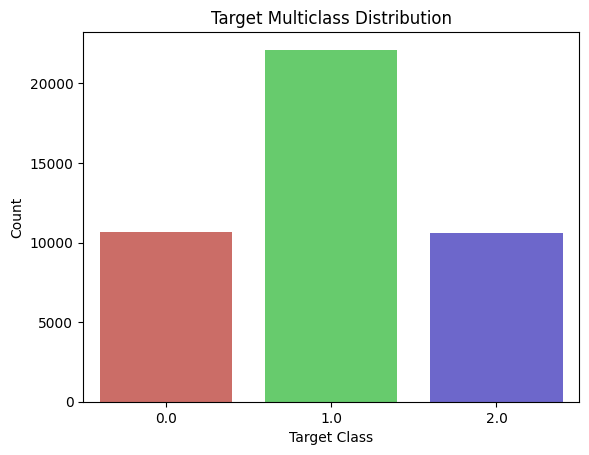

In [33]:
# Create a countplot of the target_multiclass distribution
sns.countplot(x='target_multiclass', data=df, palette='hls')

# Add a title and labels
plt.title('Target Multiclass Distribution')
plt.xlabel('Target Class')
plt.ylabel('Count')

# Show the plot
plt.show()


In [34]:
def get_event_category(timestamp):
    # Convert the timestamp to the desired time zone (e.g., GMT)
    timestamp = timestamp.tz_localize('UTC').tz_convert('GMT')

    # Check if the timestamp falls within the ECB Monetary Policy Decisions
    if timestamp.weekday() == 3 and timestamp.hour == 12 and timestamp.minute == 45: #for data base with 15 minutes separation
        return 1

    # Check if the timestamp falls within the U.S. Economic Releases
    elif timestamp.weekday() == 4 and timestamp.hour == 12 and timestamp.minute == 30:
        return 2

    # Check if the timestamp falls within the European Economic Releases
    elif timestamp.hour == 10 and timestamp.minute == 0:
        return 3

    # Check if the timestamp falls within the Overlap of U.S. and European Trading Sessions
    elif timestamp.hour >= 12 and timestamp.hour < 16:
        return 4

    # If the timestamp doesn't fall within any specific category, assign it to the "others" category
    else:
        return 5

In [35]:
def features_engineering(data):
    # Check if the input is a single row or a DataFrame
    if isinstance(data, pd.Series):
        data = pd.DataFrame(data).T

    # Moving Averages
    data['MA_10'] = data['close'].rolling(window=10).mean()
    data['MA_20'] = data['close'].rolling(window=20).mean()
    data['MA_50'] = data['close'].rolling(window=50).mean()

    # Relative Strength Index (RSI)
    delta = data['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    data['RSI'] = 100 - (100 / (1 + rs))

    # Bollinger Bands
    data['BB_middle'] = data['close'].rolling(window=20).mean()
    data['BB_std'] = data['close'].rolling(window=20).std()
    data['BB_upper'] = data['BB_middle'] + (2 * data['BB_std'])
    data['BB_lower'] = data['BB_middle'] - (2 * data['BB_std'])

    # Momentum
    data['Momentum'] = data['close'] - data['close'].shift(10)

    # Stochastic Oscillator
    data['Stochastic_K'] = ((data['close'] - data['low'].rolling(window=14).min()) /
                            (data['high'].rolling(window=14).max() - data['low'].rolling(window=14).min())) * 100
    data['Stochastic_D'] = data['Stochastic_K'].rolling(window=3).mean()

    # Lagged Features
    lags = [1, 2, 3, 5, 10]
    for lag in lags:
        data[f'close_lag_{lag}'] = data['close'].shift(lag)
        data[f'volume_lag_{lag}'] = data['tick_volume'].shift(lag)
        data[f'MA_10_lag_{lag}'] = data['MA_10'].shift(lag)
        data[f'RSI_lag_{lag}'] = data['RSI'].shift(lag)
        data[f'BB_middle_lag_{lag}'] = data['BB_middle'].shift(lag)

    # Datetime Features
    #data['hour'] = data.index.hour
    #data['day'] = data.index.day
    #data['month'] = data.index.month
    #data['year'] = data.index.year
    #data['dayofweek'] = data.index.dayofweek

    # Price Change Features
    data['price_change_1'] = data['close'].pct_change(periods=1)
    data['price_change_5'] = data['close'].pct_change(periods=5)
    data['price_change_10'] = data['close'].pct_change(periods=10)

    # Volatility Features
    data['volatility_10'] = data['close'].rolling(window=10).std()
    data['volatility_20'] = data['close'].rolling(window=20).std()
    data['volatility_50'] = data['close'].rolling(window=50).std()

    # Average True Range (ATR)
    high_low = data['high'] - data['low']
    high_close = np.abs(data['high'] - data['close'].shift())
    low_close = np.abs(data['low'] - data['close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    data['ATR'] = ranges.max(axis=1).rolling(window=14).mean()

    # Drop rows with missing values
    data.dropna(inplace=True)

    return data

In [36]:
df['event_category'] = df['datetime'].apply(get_event_category)
print(df.shape)

(43359, 9)


In [37]:
event_dummies = pd.get_dummies(df['event_category'], prefix='event', dtype=int)
df = pd.concat([df, event_dummies], axis=1)
print(df.shape)

(43359, 13)


In [38]:
# Create new features for the train dataset
featured_data = features_engineering(df)

# features for validation set
featured_data_val = features_engineering(df_val)

# features for non-seen data
featured_data_ns_test = features_engineering(non_seen_test_data)

print(featured_data.shape)
print(featured_data_val.shape)
print(featured_data_ns_test.shape)

(43309, 56)
(12452, 51)
(6120, 51)


<ipython-input-35-c6a7e58dc44a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MA_10'] = data['close'].rolling(window=10).mean()
<ipython-input-35-c6a7e58dc44a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MA_20'] = data['close'].rolling(window=20).mean()
<ipython-input-35-c6a7e58dc44a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [39]:
selected_features_names = [
    'open', 'high', 'MA_50', 'BB_std', 'BB_upper', 'BB_lower', 'Momentum',
       'close_lag_1', 'close_lag_2', 'close_lag_3', 'BB_middle_lag_5',
       'MA_10_lag_10', 'BB_middle_lag_10', 'price_change_1', 'price_change_5',
       'price_change_10', 'volatility_10', 'volatility_20', 'volatility_50',
       'ATR'
]

# Meta-model

## Call trained models

In [40]:
import joblib
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from lightgbm import LGBMClassifier
from keras.models import load_model
from sklearn.metrics import accuracy_score

In [41]:
# Define the f1_m function if it's a custom metric
def f1_m(y_true, y_pred):
    def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [42]:
# Load the base models
lg_model = joblib.load('deaf_abrax_30m_lg_model.sav')
xg_model = joblib.load('deaf_abrax_30m_xg_model.sav')

In [43]:
# Load the model with custom objects
lstm_model = load_model('best_model.hdf5', custom_objects={'f1_m': f1_m})

In [50]:
X_train = featured_data[list(selected_features_names) + ['datetime', 'target_multiclass']]
X_valid = featured_data_val[list(selected_features_names) + ['datetime', 'target_multiclass']]
y_train = X_train['target_multiclass']
y_val = df_val['target_multiclass']

In [51]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_val.shape)

(43309, 22)
(12452, 22)
(43309,)
(12452,)


In [52]:
# Extract features for training and test datasets
X_train_features = X_train[selected_features_names]
X_val_features = X_valid[selected_features_names]

In [53]:
print(X_train_features.shape)
print(X_val_features.shape)

(43309, 20)
(12452, 20)


In [54]:
# Predictions from base models on the training data
lg_train_preds = lg_model.predict_proba(X_train_features)
xg_train_preds = xg_model.predict_proba(X_train_features)
lstm_train_preds = lstm_model.predict(X_train_features)

1354/1354 [==============================] - 29s 21ms/step


In [56]:
# Predictions from base models on the test data
lg_val_preds = lg_model.predict_proba(X_val_features)
xg_val_preds = xg_model.predict_proba(X_val_features)
lstm_val_preds = lstm_model.predict(X_val_features)

390/390 [==============================] - 9s 22ms/step


In [57]:
# Create DataFrames for the base model predictions
train_base_preds = np.hstack([lg_train_preds, xg_train_preds, lstm_train_preds])
test_base_preds = np.hstack([lg_val_preds, xg_val_preds, lstm_val_preds])

In [58]:
# Split the training data into train_meta and val_meta sets
X_train_meta, X_val_meta, y_train_meta, y_val_meta = train_test_split(train_base_preds, y_train, test_size=0.1, random_state=42)

In [59]:
# Define parameter grid for LGBMClassifier
param_grid = {
   'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': sp_randint(80, 100),
    'max_depth': sp_randint(32, 84),
    'num_leaves': sp_randint(5, 31),
    'min_child_samples': sp_randint(5, 30),
    'min_child_weight': [0.001, 0.005, 0.008],
    'subsample': sp_uniform(loc=0.2, scale=0.8),
    'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
    'reg_alpha': [0],
    'reg_lambda': [0.1],
    'force_row_wise': [True]
}

In [60]:
# Create LGBMClassifier
# Define class_weight
class_weight = {0:1, 1: 0.5, 2: 1}  # Assign weights

meta_model = LGBMClassifier(class_weight=class_weight,random_state=42)

In [62]:
# A dictionary of the metrics of interest
scoring = {'f1_macro': 'f1_macro', 'f1_micro': 'f1_micro', 'roc_auc_ovr': 'roc_auc_ovr'}
# Use joblib's parallel context to specify the backend.
with joblib.parallel_backend('loky'):
    # Use RandomizedSearchCV for hyperparameter tuning
    random_search = RandomizedSearchCV(meta_model, param_distributions=param_grid, n_iter=20, cv=5, refit='roc_auc_ovr',
                                       verbose=1, n_jobs=-1, random_state=42)

In [63]:
# Fit the RandomizedSearchCV to find the best parameters
random_search.fit(X_train_meta, y_train_meta)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 38978, number of used features: 9
[LightGBM] [Info] Start training from score -1.107190
[LightGBM] [Info] Start training from score -1.071768
[LightGBM] [Info] Start training from score -1.117455


RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(class_weight={0: 1, 1: 0.5, 2: 1},
                                            random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x77facdf26e00>,
                                        'force_row_wise': [True],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_f...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x77facdf248e0>,
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x77facdf26290>,
                                        'reg_alpha': [0], 'reg_lambda': [0.1],
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x77face0c3af0>},
                   random_state=42, refit='roc_auc_ovr', verbose=1)

In [64]:
# Get the best estimator
best_meta_model = random_search.best_estimator_

In [65]:
best_meta_model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': {0: 1, 1: 0.5, 2: 1},
 'colsample_bytree': 0.9531245410138701,
 'importance_type': 'split',
 'learning_rate': 0.05,
 'max_depth': 54,
 'min_child_samples': 29,
 'min_child_weight': 0.005,
 'min_split_gain': 0.0,
 'n_estimators': 87,
 'n_jobs': None,
 'num_leaves': 25,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 0.1,
 'subsample': 0.5109418317515857,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'force_row_wise': True}

In [66]:
# Save the model to a .sav file
model_filename = 'best_meta_model.sav'
with open(model_filename, 'wb') as model_file:
    pickle.dump(best_meta_model, model_file)

print(f"Model saved to {model_filename}")

Model saved to best_meta_model.sav


In [67]:
# To load the saved model
#with open(model_filename, 'rb') as model_file:
#    loaded_meta_model = pickle.load(model_file)
#
## Verify the model loaded correctly
#print("Meta model loaded successfully!")

In [68]:
# Evaluate the meta-model
val_meta_preds = best_meta_model.predict(X_val_meta)
print(f'Validation Accuracy: {accuracy_score(y_val_meta, val_meta_preds)}')

Validation Accuracy: 0.5945509120295543


In [69]:
# Use the best meta-model to make predictions on the test set
test_meta_preds = best_meta_model.predict(test_base_preds)
print(test_meta_preds)

[0. 1. 0. ... 1. 2. 1.]


In [70]:
# If probabilities are needed, use predict_proba
test_meta_prob_preds = best_meta_model.predict_proba(test_base_preds)
print(test_meta_prob_preds)


[[0.59310924 0.18340066 0.2234901 ]
 [0.37462121 0.40669269 0.2186861 ]
 [0.7241454  0.21562445 0.06023014]
 ...
 [0.05642725 0.60527374 0.33829901]
 [0.06158027 0.43207487 0.50634486]
 [0.01737159 0.82726674 0.15536167]]


In [71]:
# prompt: convert test_meta_prob_preds and give names to each class

import pandas as pd
class_names = ['Class 0', 'Class 1', 'Class 2']

meta_model_predictions = pd.DataFrame(test_meta_prob_preds, columns=class_names)

print(meta_model_predictions.head())


    Class 0   Class 1   Class 2
0  0.593109  0.183401  0.223490
1  0.374621  0.406693  0.218686
2  0.724145  0.215624  0.060230
3  0.619462  0.317924  0.062614
4  0.052139  0.182368  0.765493


In [72]:
meta_model_predictions.shape

(12452, 3)

In [73]:
# prompt: join meta_model_predictions to df_test data,

import pandas as pd
joined_data = pd.concat([df_val.reset_index(), meta_model_predictions], axis=1)
print(joined_data.shape)


(12452, 55)


In [74]:
# prompt: new dataframe with selected_features_names plus datetime and target_multiclass features

df_to_check = joined_data[selected_features_names + ['datetime', 'target_multiclass', 'Class 0', 'Class 1', 'Class 2']]
print(df_to_check.shape)


(12452, 25)


In [75]:
df_to_check.tail(15)

,open,high,MA_50,BB_std,BB_upper,BB_lower,Momentum,close_lag_1,close_lag_2,close_lag_3,BB_middle_lag_5,MA_10_lag_10,BB_middle_lag_10,price_change_1,price_change_5,price_change_10,volatility_10,volatility_20,volatility_50,ATR,datetime,target_multiclass,Class 0,Class 1,Class 2
12437,1.08969,1.09099,1.086778,0.001768,1.089786,1.082713,0.00631,1.08970,1.08714,1.08536,1.086021,1.086463,1.086583,0.000899,0.004929,0.005819,0.002376,0.001768,0.001324,0.001231,2023-06-30 16:00:00,2.0,0.032933,0.463338,0.503729
12438,1.09067,1.09166,1.086844,0.002103,1.090669,1.082255,0.00748,1.09068,1.08970,1.08714,1.085924,1.086140,1.086450,0.000642,0.005806,0.006901,0.002773,0.002103,0.001465,0.001319,2023-06-30 16:30:00,2.0,0.521575,0.262690,0.215736
12439,1.09138,1.09318,1.086950,0.002483,1.091684,1.081753,0.00801,1.09138,1.09068,1.08970,1.085884,1.085852,1.086338,0.000916,0.006468,0.007387,0.003132,0.002483,0.001661,0.001356,2023-06-30 17:00:00,0.0,0.860232,0.045755,0.094013
12440,1.09237,1.09284,1.087032,0.002662,1.092245,1.081595,0.00644,1.09238,1.09138,1.09068,1.085902,1.085611,1.086229,-0.001254,0.003560,0.005938,0.003105,0.002662,0.001757,0.001385,2023-06-30 17:30:00,2.0,0.193956,0.140262,0.665782
12441,1.09101,1.09186,1.087078,0.002846,1.092821,1.081438,0.00718,1.09101,1.09238,1.09138,1.086056,1.085312,1.086116,0.000367,0.001569,0.006622,0.002901,0.002846,0.001840,0.001365,2023-06-30 18:00:00,2.0,0.562893,0.197219,0.239889
12442,1.09139,1.09191,1.087137,0.003038,1.093452,1.081299,0.00657,1.09141,1.09101,1.09238,1.086249,1.085147,1.086021,0.000449,0.001119,0.006053,0.002730,0.003038,0.001946,0.001358,2023-06-30 18:30:00,0.0,0.766735,0.145360,0.087905
12443,1.09190,1.09224,1.087188,0.003139,1.093926,1.081369,0.00624,1.09190,1.09141,1.09101,1.086462,1.085067,1.085924,-0.000531,-0.000055,0.005751,0.002253,0.003139,0.002022,0.001362,2023-06-30 19:00:00,2.0,0.358308,0.223835,0.417857
12444,1.09133,1.09186,1.087264,0.003258,1.094434,1.081402,0.00646,1.09132,1.09190,1.09141,1.086719,1.084962,1.085884,0.000458,-0.000513,0.005952,0.001503,0.003258,0.002123,0.001356,2023-06-30 19:30:00,1.0,0.423280,0.218720,0.358000
12445,1.09182,1.09229,1.087340,0.003351,1.094866,1.081462,0.00455,1.09182,1.09132,1.09190,1.086920,1.084999,1.085902,-0.000119,0.000623,0.004185,0.000744,0.003351,0.002212,0.001359,2023-06-30 20:00:00,0.0,0.178888,0.487615,0.333497
12446,1.09168,1.09169,1.087422,0.003360,1.095160,1.081721,0.00147,1.09169,1.09182,1.09132,1.087130,1.085405,1.086056,-0.000476,-0.000220,0.001349,0.000488,0.003360,0.002277,0.001324,2023-06-30 20:30:00,1.0,0.041742,0.883000,0.075259


## Non Seen-Data

In [76]:
non_seen_test_data.shape

(6120, 51)

<ipython-input-77-188d3e7ad818>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target_multiclass', data=non_seen_test_data, palette='hls')


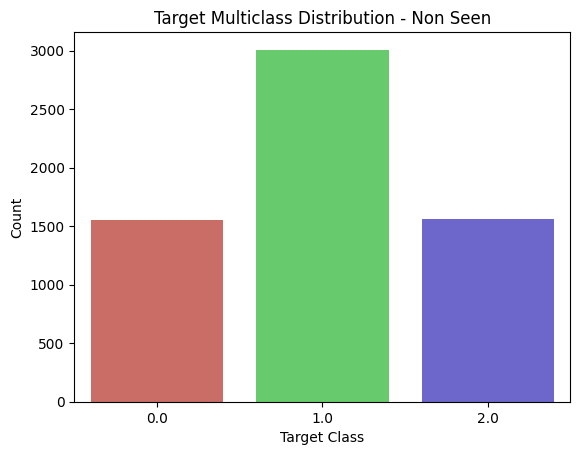

In [77]:
# prompt: plot target_multiclass distribution add colors

# Create a countplot of the target_multiclass distribution
sns.countplot(x='target_multiclass', data=non_seen_test_data, palette='hls')

# Add a title and labels
plt.title('Target Multiclass Distribution - Non Seen')
plt.xlabel('Target Class')
plt.ylabel('Count')

# Show the plot
plt.show()

In [78]:
# Predictions from base models on the training data
lg_test_preds = lg_model.predict_proba(non_seen_test_data[list(selected_features_names)])
xg_test_preds = xg_model.predict_proba(non_seen_test_data[list(selected_features_names)])
lstm_test_preds = lstm_model.predict(non_seen_test_data[list(selected_features_names)])

192/192 [==============================] - 4s 23ms/step


In [79]:
test_base_preds = np.hstack([lg_test_preds, xg_test_preds, lstm_test_preds])

In [80]:
test_meta_preds = best_meta_model.predict(test_base_preds)
print(test_meta_preds)

[1. 1. 1. ... 0. 2. 1.]


In [81]:
# If probabilities are needed, use predict_proba
test_meta_prob_preds = best_meta_model.predict_proba(test_base_preds)
print(test_meta_prob_preds)


[[0.21381295 0.58129083 0.20489622]
 [0.0537097  0.72568319 0.22060711]
 [0.02535881 0.88643522 0.08820597]
 ...
 [0.52136389 0.20492211 0.27371399]
 [0.16391465 0.178759   0.65732635]
 [0.0686563  0.49758884 0.43375486]]


In [82]:
class_names = ['Class 0', 'Class 1', 'Class 2']

meta_model_predictions = pd.DataFrame(test_meta_prob_preds, columns=class_names)

print(meta_model_predictions.head())

meta_model_predictions.shape


    Class 0   Class 1   Class 2
0  0.213813  0.581291  0.204896
1  0.053710  0.725683  0.220607
2  0.025359  0.886435  0.088206
3  0.014464  0.871176  0.114361
4  0.127041  0.638170  0.234789


(6120, 3)

In [83]:
# prompt: join meta_model_predictions to df_test data,

joined_data_test = pd.concat([non_seen_test_data.reset_index(), meta_model_predictions], axis=1)
print(joined_data_test.shape)

(6120, 55)


In [84]:
# prompt: new dataframe with selected_features_names plus datetime and target_multiclass features

df_to_check_test = joined_data_test[selected_features_names + ['datetime', 'target_multiclass', 'Class 0', 'Class 1', 'Class 2']]
print(df_to_check_test.shape)

(6120, 25)


In [85]:
df_to_check_test.tail(15)

,open,high,MA_50,BB_std,BB_upper,BB_lower,Momentum,close_lag_1,close_lag_2,close_lag_3,BB_middle_lag_5,MA_10_lag_10,BB_middle_lag_10,price_change_1,price_change_5,price_change_10,volatility_10,volatility_20,volatility_50,ATR,datetime,target_multiclass,Class 0,Class 1,Class 2
6105,1.10487,1.10587,1.106891,0.000948,1.108187,1.104395,0.00040,1.10487,1.10545,1.10517,1.106552,1.106619,1.106893,0.000643,-0.001869,0.000362,0.001096,0.000948,0.001299,0.001219,2023-12-29 16:00:00,2.0,0.454971,0.330710,0.214319
6106,1.10558,1.10702,1.106882,0.000953,1.108207,1.104395,0.00195,1.10558,1.10487,1.10545,1.106572,1.106444,1.106800,0.001158,-0.000966,0.001765,0.001060,0.000953,0.001298,0.001321,2023-12-29 16:30:00,2.0,0.387151,0.268266,0.344583
6107,1.10689,1.10764,1.106852,0.000989,1.108338,1.104381,0.00215,1.10686,1.10558,1.10487,1.106473,1.106346,1.106709,0.000569,0.002099,0.001945,0.001094,0.000989,0.001265,0.001306,2023-12-29 17:00:00,0.0,0.234885,0.383598,0.381516
6108,1.10747,1.10785,1.106741,0.001052,1.108369,1.104160,-0.00178,1.10749,1.10686,1.10558,1.106419,1.106334,1.106653,-0.002501,-0.000660,-0.001609,0.001209,0.001052,0.001201,0.001436,2023-12-29 17:30:00,2.0,0.042440,0.026993,0.930567
6109,1.10473,1.10606,1.106625,0.001057,1.108303,1.104074,-0.00083,1.10472,1.10749,1.10686,1.106336,1.106265,1.106564,0.000616,0.000480,-0.000750,0.001235,0.001057,0.001026,0.001479,2023-12-29 18:00:00,2.0,0.611361,0.230419,0.158220
6110,1.10542,1.10614,1.106533,0.001023,1.108172,1.104081,-0.00156,1.10540,1.10472,1.10749,1.106291,1.106297,1.106552,0.000624,0.000461,-0.001408,0.001111,0.001023,0.000846,0.001486,2023-12-29 18:30:00,1.0,0.507121,0.175397,0.317482
6111,1.10610,1.10629,1.106505,0.001007,1.108098,1.104070,-0.00190,1.10609,1.10540,1.10472,1.106301,1.106402,1.106572,-0.000054,-0.000750,-0.001715,0.000873,0.001007,0.000838,0.001492,2023-12-29 19:00:00,2.0,0.107088,0.372082,0.520831
6112,1.10602,1.10668,1.106489,0.001003,1.108080,1.104068,0.00123,1.10603,1.10609,1.10540,1.106360,1.106259,1.106473,0.000335,-0.000984,0.001113,0.000867,0.001003,0.000832,0.001450,2023-12-29 19:30:00,0.0,0.426184,0.234997,0.338819
6113,1.10641,1.10641,1.106450,0.000951,1.107857,1.104053,-0.00022,1.10640,1.10603,1.10609,1.106265,1.106043,1.106419,-0.001057,0.000462,-0.000199,0.000882,0.000951,0.000845,0.001517,2023-12-29 20:00:00,1.0,0.234150,0.382813,0.383036
6114,1.10522,1.10599,1.106408,0.000961,1.107839,1.103994,0.00043,1.10523,1.10640,1.10603,1.106189,1.105923,1.106336,0.000063,-0.000090,0.000389,0.000837,0.000961,0.000849,0.001480,2023-12-29 20:30:00,0.0,0.574234,0.245965,0.179801


# Conformal Predictions

In [86]:
conformal_dataset = pd.read_csv('/content/drive/MyDrive/DeafAbraxas/data/30m/conformal_dataset.csv',delimiter=",")
print(conformal_dataset.shape)

(5160, 7)


In [87]:
print(conformal_dataset.datetime.head(1))
print(conformal_dataset.datetime.tail(1))

0    2024-01-02 09:30:00
Name: datetime, dtype: object
5159    2024-05-31 00:00:00
Name: datetime, dtype: object


In [88]:
#convert datatime to_datetime
conformal_dataset.rename(columns={"time": "datetime"}, inplace=True)
conformal_dataset['datetime'] = pd.to_datetime(conformal_dataset['datetime'])

In [89]:
pip_changes_conformal = (conformal_dataset['close'].shift(-1) - conformal_dataset['close']) * 10000

In [90]:
pip_ranges_conformal = [-np.inf ,-3.0, 3.0, np.inf]

#target for conformal
conformal_dataset['target_multiclass'] = pd.cut((conformal_dataset['close'].shift(-1) - conformal_dataset['close']) * 10000, bins=pip_ranges_conformal, labels=False)


<ipython-input-91-96c9ba0ee8f4>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target_multiclass', data=conformal_dataset, palette='hls')


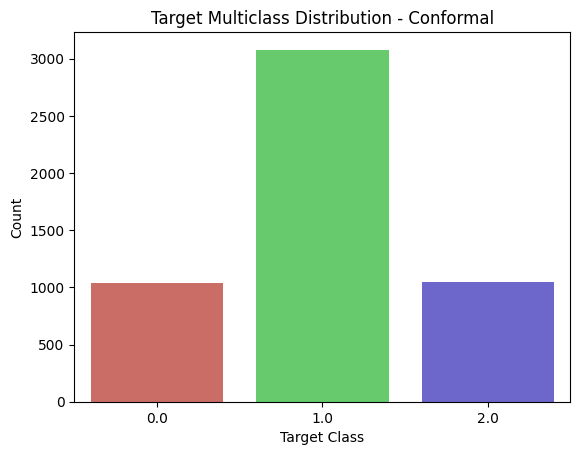

In [91]:
# prompt: plot target_multiclass distribution add colors

# Create a countplot of the target_multiclass distribution
sns.countplot(x='target_multiclass', data=conformal_dataset, palette='hls')

# Add a title and labels
plt.title('Target Multiclass Distribution - Conformal')
plt.xlabel('Target Class')
plt.ylabel('Count')

# Show the plot
plt.show()


In [92]:
# features for non-seen data
featured_conformal = features_engineering(conformal_dataset)

In [93]:
print(featured_conformal.shape)

(5110, 51)


In [94]:
# Columns used for modeling, make sure these matches your training columns
conformal_data_features = featured_conformal[selected_features_names]
#conformal_data_features = df_to_model[columns_to_model]

In [95]:
conformal_data_features.head()

,open,high,MA_50,BB_std,BB_upper,BB_lower,Momentum,close_lag_1,close_lag_2,close_lag_3,BB_middle_lag_5,MA_10_lag_10,BB_middle_lag_10,price_change_1,price_change_5,price_change_10,volatility_10,volatility_20,volatility_50,ATR
49,1.09601,1.09655,1.096236,0.000654,1.096614,1.093999,-0.00003,1.09604,1.09576,1.09587,1.094917,1.094800,1.094686,-0.000666,0.000173,-0.000027,0.000351,0.000654,0.002477,0.000633
50,1.09530,1.09578,1.096110,0.000585,1.096536,1.094197,-0.00083,1.09531,1.09604,1.09576,1.094975,1.095003,1.094738,-0.000046,-0.000465,-0.000757,0.000376,0.000585,0.002359,0.000654
51,1.09526,1.09563,1.095930,0.000632,1.096608,1.094082,-0.00216,1.09526,1.09531,1.09604,1.095053,1.095176,1.094769,-0.001260,-0.001816,-0.001971,0.000677,0.000632,0.002167,0.000764
52,1.09388,1.09442,1.095743,0.000694,1.096706,1.093929,-0.00262,1.09388,1.09526,1.09531,1.095146,1.095383,1.094846,-0.000238,-0.001953,-0.002390,0.000850,0.000694,0.001938,0.000802
53,1.09361,1.09390,1.095536,0.000864,1.096952,1.093496,-0.00290,1.09362,1.09388,1.09526,1.095241,1.095486,1.094893,-0.000576,-0.002783,-0.002646,0.001073,0.000864,0.001640,0.000837


In [96]:
# Define your target variable, ensure to replace with your actual target column
y_conformal = conformal_dataset.target_multiclass

In [97]:
# Predict probabilities for each base model
lg_preds = lg_model.predict_proba(conformal_data_features)
xg_preds = xg_model.predict_proba(conformal_data_features)
lstm_preds = lstm_model.predict(conformal_data_features)

160/160 [==============================] - 4s 22ms/step


In [98]:
# Combine these probabilities into a single input for the meta-model
combined_preds = np.hstack([lg_preds, xg_preds, lstm_preds])

In [99]:
# Predict class probabilities with the meta-model
final_proba = best_meta_model.predict_proba(combined_preds)

**1.Computing statistics:**

- The code calculates various statistics on the final_proba array, which likely contains the predicted probabilities for each class.
- np.median(final_proba, axis=0) computes the median probability for each class across all instances.
- np.max(final_proba, axis=0) and np.min(final_proba, axis=0) calculate the maximum and minimum probabilities for each class across all instances.
- np.std(final_proba, axis=0) computes the standard deviation of the probabilities for each class across all instances.
- np.mean(final_proba, axis=0) calculates the mean probability for each class across all instances.

In [100]:
# prompt: compute median, std, mean in final_proba positions
median = np.median(final_proba, axis=0)
print(median)
max_val = np.max(final_proba, axis=0)
print(max_val)
min_val = np.min(final_proba, axis=0)
print(min_val)
std = np.std(final_proba, axis=0)
print(std)
mean = np.mean(final_proba, axis=0)
print(mean)

[0.23646662 0.37076974 0.25089436]
[0.94295709 0.98023299 0.96850858]
[0.00631076 0.01906904 0.01196474]
[0.22335695 0.22903957 0.20835726]
[0.27734468 0.41931059 0.30334473]


**2. Computing non-conformity scores:**

- The code calculates non-conformity scores using the mean and standard deviation of the probabilities.
- norm_mean = (final_proba - mean) / std normalizes the probabilities by subtracting the mean and dividing by the standard deviation for each class.
- The comment suggests considering other composite non-conformity scores as an alternative.

In [101]:
# Compute non-conformity scores using mean and std, normalizing by mean
norm_mean = (final_proba - mean) / std
# Alternatively, consider other composite non-conformity scores

**3. Example of max gap approach:**

- The code demonstrates an example of the max gap approach to compute instance uncertainty.
- non_conformity_scores = 1 - np.max(norm_mean, axis=1) calculates the non-conformity score for each instance by subtracting the maximum normalized probability across all classes from 1.
- This approach measures the uncertainty of each instance based on the gap between the highest normalized probability and 1.

In [102]:
# Example of max gap approach per row (Instance uncertainty)
non_conformity_scores = 1 - np.max(norm_mean, axis=1)

**4. Desired confidence level (alpha):**

- **alpha = 0.15** sets the desired confidence level for the conformal predictions.
- The confidence level represents the proportion of instances for which the true label is expected to be included in the predicted set.(*In this case, alpha = 0.15 means that the conformal predictions aim to include the true label for at least 85% of the instances.*)

- Sorting non-conformity scores:
sorted_scores = np.sort(non_conformity_scores) sorts the non-conformity scores in ascending order.

- **Calculating the threshold:**

- quantile_index = int(np.ceil((1 - alpha) * len(sorted_scores))) - 1 calculates the index of the quantile corresponding to the desired confidence level.
- It uses np.ceil() to round up the index to the nearest integer and subtracts 1 to account for zero-based indexing.
- The code ensures that the quantile_index is within the valid range of indices for sorted_scores using min() and max().
- **threshold =** sorted_scores[quantile_index] retrieves the non-conformity score at the calculated quantile index as the threshold.


In [106]:
# Desired confidence level (alpha)
alpha = 0.15

# Sort non-conformity scores
sorted_scores = np.sort(non_conformity_scores)

# Calculate quantile index for the threshold
quantile_index = int(np.ceil((1 - alpha) * len(sorted_scores))) - 1

# Ensure index is within bounds
quantile_index = min(max(quantile_index, 0), len(sorted_scores) - 1)

threshold = sorted_scores[quantile_index]
print("Threshold: ", threshold)

Threshold:  0.4714430394208391


In [107]:
with open('deaf_abrax_30m_conformal_thr.sav', 'wb') as f:
    pickle.dump(threshold, f)

In [ ]:
!python -c "import tensorflow as tf; print(tf.__version__)"

2024-06-09 18:07:40.355399: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 18:07:40.355482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 18:07:40.356385: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-09 18:07:41.351475: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2.15.0


In [ ]:
!python -c "import keras; print(keras.__version__)"

2024-06-09 18:07:43.967233: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 18:07:43.967295: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 18:07:43.968087: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-09 18:07:44.910591: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2.15.0
